# Fisheries Employment

Visualizing employment in the fishing sector as a proportion of total employmnet in Natural Sectors (agriculture, forestry, and hunting)

*Author: Rachel Thoms
<br>Created: 24 Aug 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type
- Value 

## Data

- Data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (full dataset - []())
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/)
- Source: []()

## Preparation

### Aliasing and Inserting Data

#### Queries

Query 1

``` SQL
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'goods_services' AS section, 'fishing employment' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit 
FROM (SELECT area, year, obs_value, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) data
LEFT JOIN (SELECT DISTINCT(iso), name_0 FROM ow_aliasing_countries) AS alias ON data.area = alias.iso WHERE alias.iso IS NOT NULL
```

- countries with data: 170
- rows before: 143460
- rows inserted: 5028
- rows after: 148488

Query 2

```sql
INSERT INTO ow_widget_territory(section, widget, gid_0, name_0, variable, date, value, unit)
SELECT 'goods_services' AS section, 'fishing employment' AS widget, alias.iso AS gid_0, alias.name_0 AS name_0, CONCAT(data.type, ' ', data.sex) AS variable, data.year AS date, data.obs_value AS value, data.unit AS unit 
FROM (SELECT area, year, obs_value, concat(type, ' Employment ') AS type, sex, '1000 people' AS unit FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL) data
LEFT JOIN (SELECT DISTINCT(area), obs_value as rev4 FROM com_037_rw0_fishing_employment_edit WHERE obs_value IS NOT NULL AND rev = 4) rev4 ON rev4.area = data.area 
LEFT JOIN (SELECT DISTINCT(iso), name_0 FROM ow_aliasing_countries) AS alias ON data.area = alias.iso WHERE alias.iso IS NOT NULL AND rev4.rev4 IS NULL
```

- countries with data: 23
- rows before: 148488
- rows inserted: 496
- rows after: 148984

```sql

```

### Vega

In [12]:
import json
from vega import Vega
from IPython.display import display

In [13]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [14]:
widget_width = 800
widget_height = 300

## Visualization

### Queries

#### Testing

```gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d'``` used as stand-in for parameterized ```{{{geostore_env}}='{{geostore_id}}'``` in production version

```sql
SELECT gadm.gid_0, gadm.name_0, date, variable, value, unit FROM ow_widget_territory AS data 
LEFT OUTER JOIN gadm36_0 gadm ON data.gid_0 = gadm.gid_0 WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' AND widget = 'fishing employment' ORDER BY date ASC, variable ASC

```

#### Parameterized

```sql
SELECT gadm.gid_0, gadm.name_0, date, variable, value, unit FROM ow_widget_territory AS data LEFT OUTER JOIN gadm36_0 gadm ON data.gid_0 = gadm.gid_0 WHERE gadm.{{geostore_env}} ILIKE '{{geostore_id}}' AND widget = 'fishing employment' ORDER BY date ASC, variable ASC
```

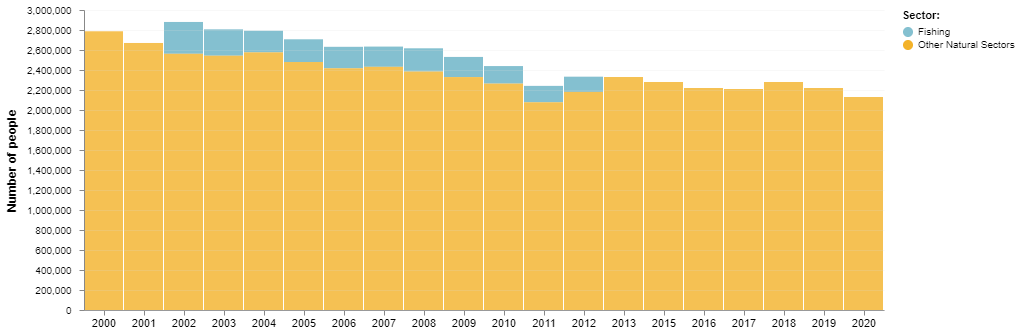

In [15]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "A searchable, stacked area chart of U.S. occupations from 1850 to 2000.",
  "width": 800,
  "height": 300,
  "padding": 5,
  "signals": [
    {
      "name": "sex",
      "value": "Total",
      "bind": {"input": "select", "options": ["Total", "Male", "Female"]}
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gadm.gid_0, gadm.name_0, date, variable, value, unit FROM ow_widget_territory AS data LEFT OUTER JOIN gadm36_0 gadm ON data.gid_0 = gadm.gid_0 WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' AND widget = 'fishing employment' ORDER BY date ASC, variable ASC ",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {"type": "stack", "field": "value", "groupby": ["gid_0", "date"]},
        {
          "type": "formula",
          "expr": "split(datum.variable, ' Employment')[0]",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "split(datum.variable, '_')[1]",
          "as": "sex"
        },
        {"type": "formula", "expr": "datum.value*1000", "as": "value"},
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "pivot",
          "groupby": ["gid_0", "date", "sex"],
          "field": "sector",
          "value": "value"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing > datum.Natural_Sector_Total ? null: datum.Natural_Sector_Total",
          "as": "Natural_Sector_Total"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing ? datum.Natural_Sector_Total - datum.Fishing: datum.Natural_Sector_Total",
          "as": "Other Natural Sectors"
        },
        {
          "type": "fold",
          "fields": ["Fishing", "Other Natural Sectors"],
          "as": ["sector", "value"]
        },
        {"type": "filter", "expr": "isValid(datum.Natural_Sector_Total)"},
        {
          "type": "stack",
          "field": "value",
          "groupby": ["date", "sex"],
          "sort": {
            "field": ["gid_0", "date", "sector"],
            "order": ["descending", "ascending", "descending"]
          }
        }
      ]
    },
    {
      "name": "filter",
      "source": "table",
      "transform": [
        {
          "type": "formula",
          "expr": "test(/M/, datum.sex) ? 'Male': test(/F/, datum.sex) ? 'Female' : 'Total'",
          "as": "sex"
        },
        {"type": "filter", "expr": "datum.sex==sex"}
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "range": "width",
      "domain": {"data": "filter", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "table", "field": "y1"}
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#84c0d0", "#f3b229"],
      "domain": {"data": "filter", "field": "sector"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "zindex": 1,
      "labelFont": "Arial",
      "labelFontSize": 11,
      "labelOverlap": true
    },
    {
      "orient": "left",
      "scale": "y",
      "zindex": 1,
      "title": "Number of people",
      "titlePadding": 8,
      "titleFontSize": 12,
      "labelFont": "Arial",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 8,
      "ticks": true,
      "tickSize": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "encode": {
        "labels": {"update": {"text": {"signal": "format(datum.value, ',')"}}}
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "filter"},
      "encode": {
        "enter": {
          "x": {"scale": "x", "field": "date"},
          "width": {"scale": "x", "band": 1, "offset": -1},
          "y": {"scale": "y", "field": "y0"},
          "y2": {"scale": "y", "field": "y1"},
          "fill": {"scale": "color", "field": "sector"},
          "tooltip": {
            "signal": "{'Year': datum.date, 'Employment sector': (datum.sector === 'Other Natural Sectors' ? 'Agriculture & Forestry' : datum.sector), 'Employment: ': format(datum.value, ',.5r')}"
          }
        },
        "update": {
          "fillOpacity": [
            {
              "test": "test(/Other Natural Sectors/, datum.sector)",
              "value": 0.8
            },
            {"value": 1}
          ]
        },
        "hover": {"fillOpacity": {"value": 0.7}}
      }
    }
  ],
  "legends": [{"title": ["Sector:"], "fill": "color", "orient": "right"}]
}""")
vegaview=dict(spec)
Vega(vegaview)

# With Country Selector

In [16]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json"
  "width": 800,
  "height": 300,
  "padding": 5,
  "signals": [
    {
      "name": "sex",
      "value": "Total",
      "bind": {"input": "select", "options": ["Total", "Male", "Female"]}
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gadm.gid_0, gadm.name_0, date, variable, value, unit FROM ow_widget_territory AS data LEFT OUTER JOIN gadm36_0 gadm ON data.gid_0 = gadm.gid_0 WHERE gadm.geostore_prod ILIKE 'ca5bfde08587530e76c17fe48362a01d' AND widget = 'fishing employment' ORDER BY date ASC, variable ASC ",
      "format": {"type": "json", "property": "rows"},
      "transform": [
        {"type": "stack", "field": "value", "groupby": ["gid_0", "date"]},
        {
          "type": "formula",
          "expr": "split(datum.variable, ' Employment')[0]",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "split(datum.variable, '_')[1]",
          "as": "sex"
        },
        {"type": "formula", "expr": "datum.value*1000", "as": "value"},
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "formula",
          "expr": "replace(datum.sector, ' ', '_')",
          "as": "sector"
        },
        {
          "type": "pivot",
          "groupby": ["gid_0", "date", "sex"],
          "field": "sector",
          "value": "value"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing > datum.Natural_Sector_Total ? null: datum.Natural_Sector_Total",
          "as": "Natural_Sector_Total"
        },
        {
          "type": "formula",
          "expr": "datum.Fishing ? datum.Natural_Sector_Total - datum.Fishing: datum.Natural_Sector_Total",
          "as": "Other Natural Sectors"
        },
        {
          "type": "fold",
          "fields": ["Fishing", "Other Natural Sectors"],
          "as": ["sector", "value"]
        },
        {"type": "filter", "expr": "isValid(datum.Natural_Sector_Total)"},
        {
          "type": "stack",
          "field": "value",
          "groupby": ["date", "sex"],
          "sort": {
            "field": ["gid_0", "date", "sector"],
            "order": ["descending", "ascending", "descending"]
          }
        }
      ]
    },
    {
      "name": "filter",
      "source": "table",
      "transform": [
        {
          "type": "formula",
          "expr": "test(/M/, datum.sex) ? 'Male': test(/F/, datum.sex) ? 'Female' : 'Total'",
          "as": "sex"
        },
        {"type": "filter", "expr": "datum.sex==sex"}
      ]
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "band",
      "range": "width",
      "domain": {"data": "filter", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "table", "field": "y1"}
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#84c0d0", "#f3b229"],
      "domain": {"data": "filter", "field": "sector"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "zindex": 1,
      "labelFont": "Arial",
      "labelFontSize": 11,
      "labelOverlap": true
    },
    {
      "orient": "left",
      "scale": "y",
      "zindex": 1,
      "title": "Number of people",
      "titlePadding": 8,
      "titleFontSize": 12,
      "labelFont": "Arial",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 8,
      "ticks": true,
      "tickSize": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "encode": {
        "labels": {"update": {"text": {"signal": "format(datum.value, ',')"}}}
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "from": {"data": "filter"},
      "encode": {
        "enter": {
          "x": {"scale": "x", "field": "date"},
          "width": {"scale": "x", "band": 1, "offset": -1},
          "y": {"scale": "y", "field": "y0"},
          "y2": {"scale": "y", "field": "y1"},
          "fill": {"scale": "color", "field": "sector"},
          "tooltip": {
            "signal": "{'Year': datum.date, 'Employment sector': (datum.sector === 'Other Natural Sectors' ? 'Agriculture & Forestry' : datum.sector), 'Employment: ': format(datum.value, ',.5r')}"
          }
        },
        "update": {
          "fillOpacity": [
            {
              "test": "test(/Other Natural Sectors/, datum.sector)",
              "value": 0.8
            },
            {"value": 1}
          ]
        },
        "hover": {"fillOpacity": {"value": 0.7}}
      }
    }
  ],
  "legends": [{"title": ["Sector:"], "fill": "color", "orient": "right"}]
}
""")
vegaview=dict(spec)
Vega(vegaview)

JSONDecodeError: Expecting ',' delimiter: line 3 column 3 (char 62)

## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/49e474c1-014b-476c-b832-8c9a556ad6e3/edit?dataset=4487e012-9571-4175-991a-101268d6bb3f)
- parent dataset [com.037.rw0](https://resourcewatch.org/data/explore/4487e012-9571-4175-991a-101268d6bb3f) (unpublished)
- dataset id ```4487e012-9571-4175-991a-101268d6bb3f```
- widget id: ```49e474c1-014b-476c-b832-8c9a556ad6e3```